<img src="https://upload.wikimedia.org/wikipedia/commons/f/f2/Sphere5tesselation.gif" alt="Tiling of the sphere by spherical triangles"></img>

# Spherical Polygons and Areas

---

## Overview
Determine the calculations of a spherical polygons based on a unit sphere

1. Determine clockwise/counterclockwise ordering of points on spherical polygon
1. Area and Permieter of quadrilateral patch on a unit sphere
1. Determine if a given point is within a spherical polygon
1. Center of spherical polygon

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Numpy](https://foundations.projectpythia.org/core/numpy.html) | Necessary | |
| [Pandas](https://foundations.projectpythia.org/core/numpy.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Will be used for plotting |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Helpful | Will be used for plotting |

- **Time to learn**: 40 minutes

---

## Imports

In [230]:
import pandas as pd       # reading in data for location information from text file
#import numpy as np        # working with arrays, vectors, cross/dot products, and radians

from pyproj import Geod   # working with the Earth as an ellipsod (WGS-84)

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib.pyplot as plt                        # plotting a graph
from cartopy import crs as ccrs, feature as cfeature   # plotting a world map

In [231]:
# Get all Coordinates for Locations
location_df = pd.read_csv("../location_full_coords.txt")
location_df = location_df.rename(columns=lambda x: x.strip()) # strip excess white space from column names and values
location_df.head()

,name,latitude,longitude,cart_x,cart_y,cart_z,rho,theta,phi,polar_x,polar_y,polar_z
0,arecibo,18.3441,-66.7527,2.389526e+06,-5.562495e+06,2.007347e+06,6378137.0,-1.165054,1.250631,-5.562495e+06,2.389526e+06,2.007347e+06
1,boulder,40.0150,-105.2705,-1.286558e+06,-4.712394e+06,4.101066e+06,6378137.0,1.304276,0.872403,-4.712394e+06,-1.286558e+06,4.101066e+06
2,boston,42.3601,-71.0589,1.529809e+06,-4.457769e+06,4.297512e+06,6378137.0,-1.240212,0.831473,-4.457769e+06,1.529809e+06,4.297512e+06
3,redwoods,41.4017,-124.0417,-2.678169e+06,-3.964322e+06,4.218080e+06,6378137.0,0.976657,0.848200,-3.964322e+06,-2.678169e+06,4.218080e+06
4,houston,29.5518,-95.0982,-4.930480e+05,-5.526456e+06,3.145762e+06,6378137.0,1.481816,1.055020,-5.526456e+06,-4.930480e+05,3.145762e+06


In [232]:
location_df.index = location_df["name"]

## Determine clockwise/counterclockwise ordering of points on spherical polygon

- True: when input points are in a clockwise order
- False: when input points are in a counterclockwise (or co-linear) order

### Shoelace Formula for Signed Polygon Area

TODO

In [233]:
def is_clockwise(pt_lst=None):
    # signed polygon area -> shoelace formula
    # postive = counterclockwise, negative = clockwise
    area = 0
    for i in range(0, len(pt_lst)):
        if i+1 < len(pt_lst):
            area += location_df.loc[[pt_lst[i]]]["latitude"].iloc[0] * location_df.loc[[pt_lst[i+1]]]["longitude"].iloc[0]
            area -= location_df.loc[[pt_lst[i+1]]]["latitude"].iloc[0]  * location_df.loc[[pt_lst[i]]]["longitude"].iloc[0]
        #area /= 2 # determine full sign area, unneeded when just working with signs
    if area < 0: 
        print("clockwise -> negative")
        return True
    if area > 0:
        print("counterclockwise -> postive")
        return False
    if area == 0:
        print("non-collinear -> zero") #https://en.wikipedia.org/wiki/Curve_orientation
        return False

In [234]:
is_clockwise(["boulder", "boston", "houston"])

clockwise -> negative


True

In [235]:
def plot_clockwise(pt_lst=None,
                   lon_west=-180, lon_east=180,
                   lat_south=-90, lat_north=90):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")

    # plot arrow between points in order
    for i, pt in enumerate(pt_lst):
        if i+1 < len(pt_lst):
            ax.quiver(location_df.loc[[pt_lst[i]]]["longitude"].iloc[0],
                      location_df.loc[[pt_lst[i]]]["latitude"].iloc[0], 
                      (location_df.loc[[pt_lst[i+1]]]["longitude"].iloc[0]-location_df.loc[[pt_lst[i]]]["longitude"].iloc[0]), 
                      (location_df.loc[[pt_lst[i+1]]]["latitude"].iloc[0]-location_df.loc[[pt_lst[i]]]["latitude"].iloc[0]), 
                      angles='xy', scale_units='xy', scale=1)   
   # plot points
    longitudes = [location_df.loc[[x]]["longitude"].iloc[0] for x in pt_lst] # longitude
    latitudes = [location_df.loc[[x]]["latitude"].iloc[0] for x in pt_lst] # latitude
    plt.scatter(longitudes, latitudes, s=100, c="red")
    if is_clockwise(pt_lst):
        clockwise = "Clockwise"
    else:
        clockwise = "Counterclockwise"
    plt.title(clockwise)
    plt.show()

clockwise -> negative


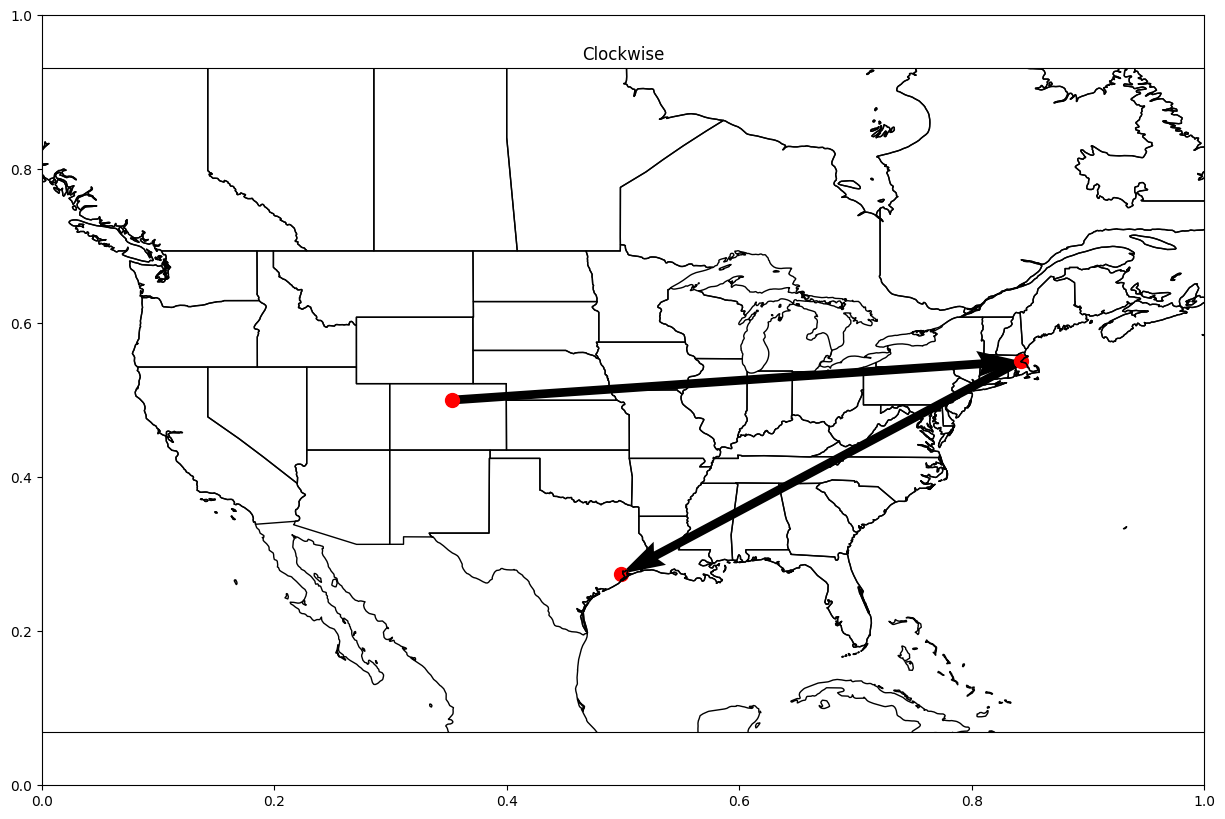

In [236]:
plot_clockwise(["boulder", "boston", "houston"], -130, -60, 20, 60)

counterclockwise -> postive


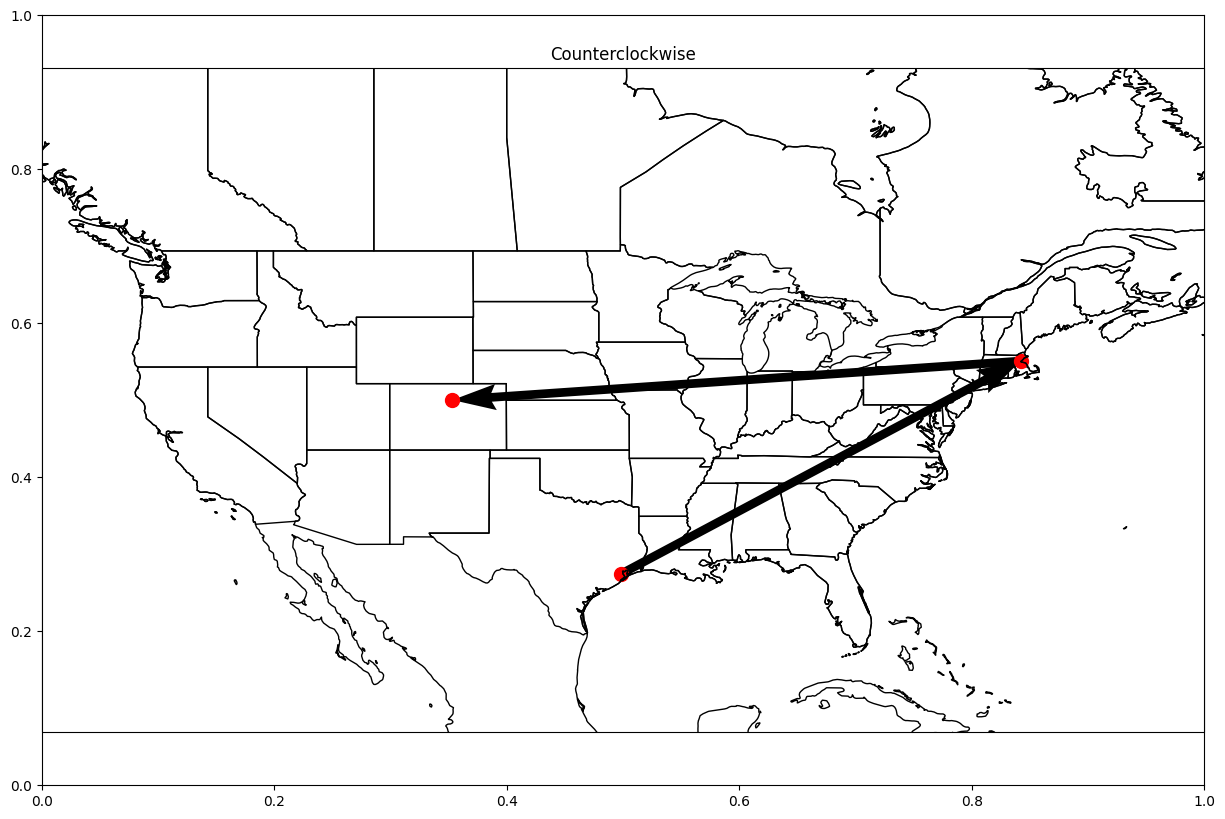

In [237]:
plot_clockwise(["houston", "boston", "boulder"], -130, -60, 20, 60)

counterclockwise -> postive


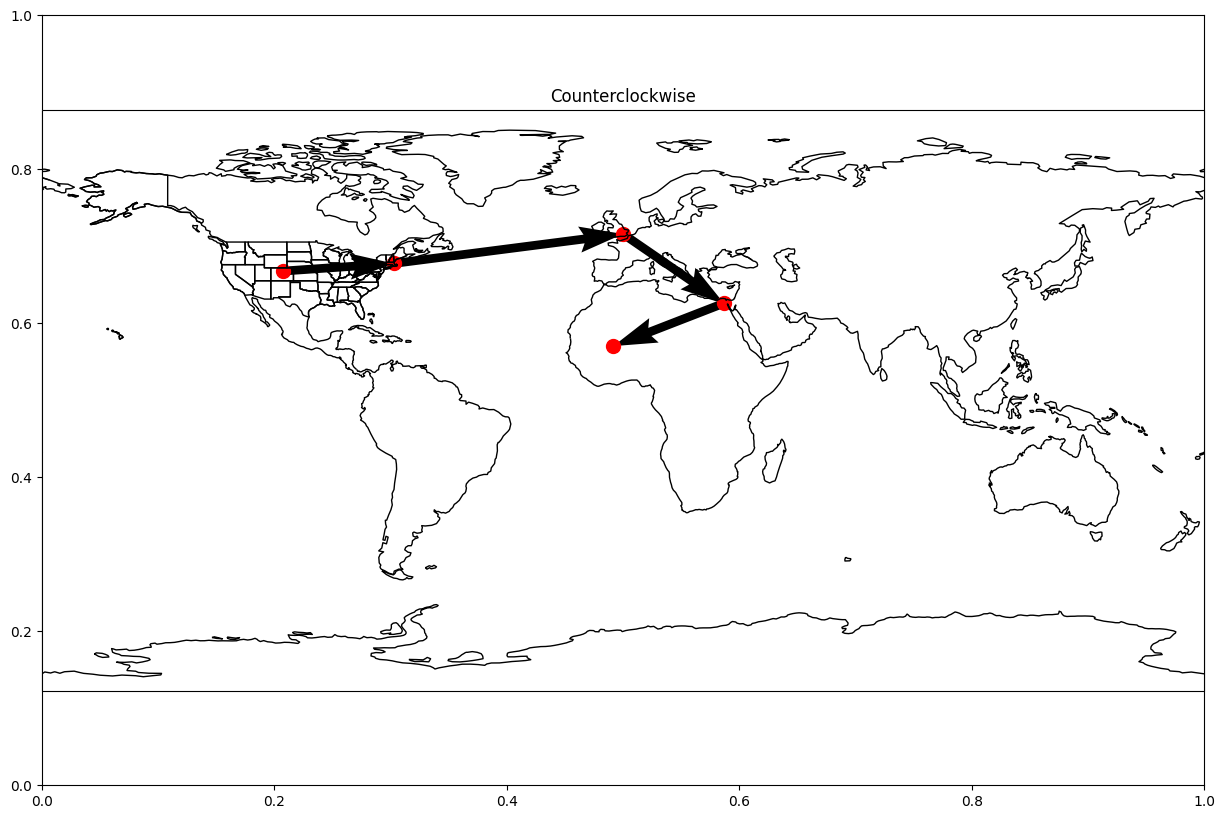

In [238]:
plot_clockwise(["boulder", "boston", "greenwich", "cairo", "timbuktu"])

## Area and Perimeter of quadrilateral patch

In [239]:
def area_of_polygon_projection(poly_pts=None):
    geod = Geod(ellps="WGS84")
    longitudes = [location_df.loc[[pt]]["longitude"].iloc[0] for pt in poly_pts]
    latitudes = [location_df.loc[[pt]]["latitude"].iloc[0] for pt in poly_pts]
    poly_area_m, poly_perimeter_m = geod.polygon_area_perimeter(longitudes, latitudes)
    return abs(poly_area_m) * 1e-6, poly_perimeter_m/1000

In [240]:
def plot_area(pt_lst=None,
                   lon_west=-180, lon_east=180,
                   lat_south=-90, lat_north=90):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")

   # plot points
    longitudes = [location_df.loc[[x]]["longitude"].iloc[0] for x in pt_lst] # longitude
    latitudes = [location_df.loc[[x]]["latitude"].iloc[0] for x in pt_lst] # latitude
    plt.scatter(longitudes, latitudes, s=100, c="red")
    plt.fill(longitudes, latitudes, alpha=0.5)

    area, perimeter = area_of_polygon_projection(pt_lst)
    plt.title(f"Roughly {(area/509600000)*100:.2f}% of the Earth's Surface")
    plt.show()

In [241]:
area, perimeter = area_of_polygon_projection(["boulder", "boston",
                                             "arecibo", "houston"])
print(f"Perimeter = {perimeter} km")
print(f"Area = {area} km^2")
print(f"Roughly {(area/509600000)*100:.2f}% of the Earth's Surface")

Perimeter = 10171.738963248145 km
Area = 5342585.647699828 km^2
Roughly 1.05% of the Earth's Surface


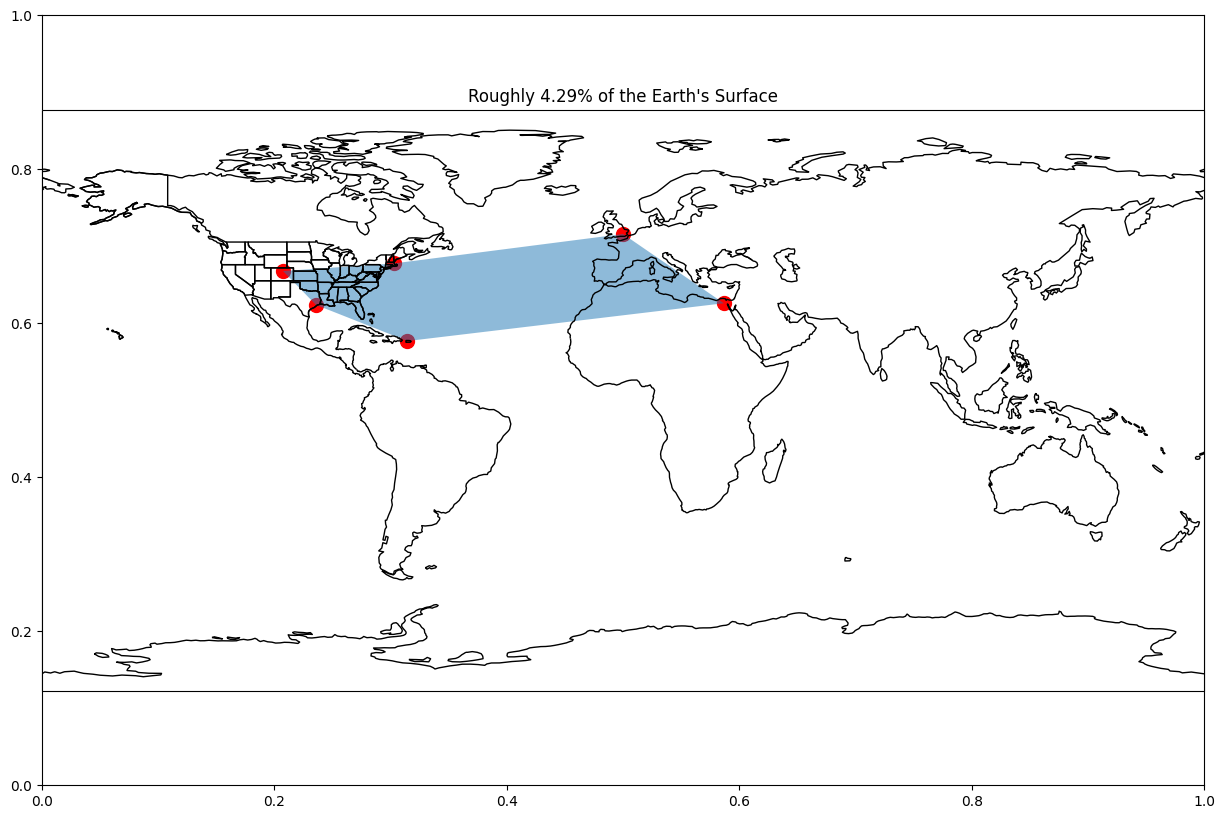

In [242]:
plot_area(["boulder", "boston", "greenwich", "cairo", "arecibo", "houston"])

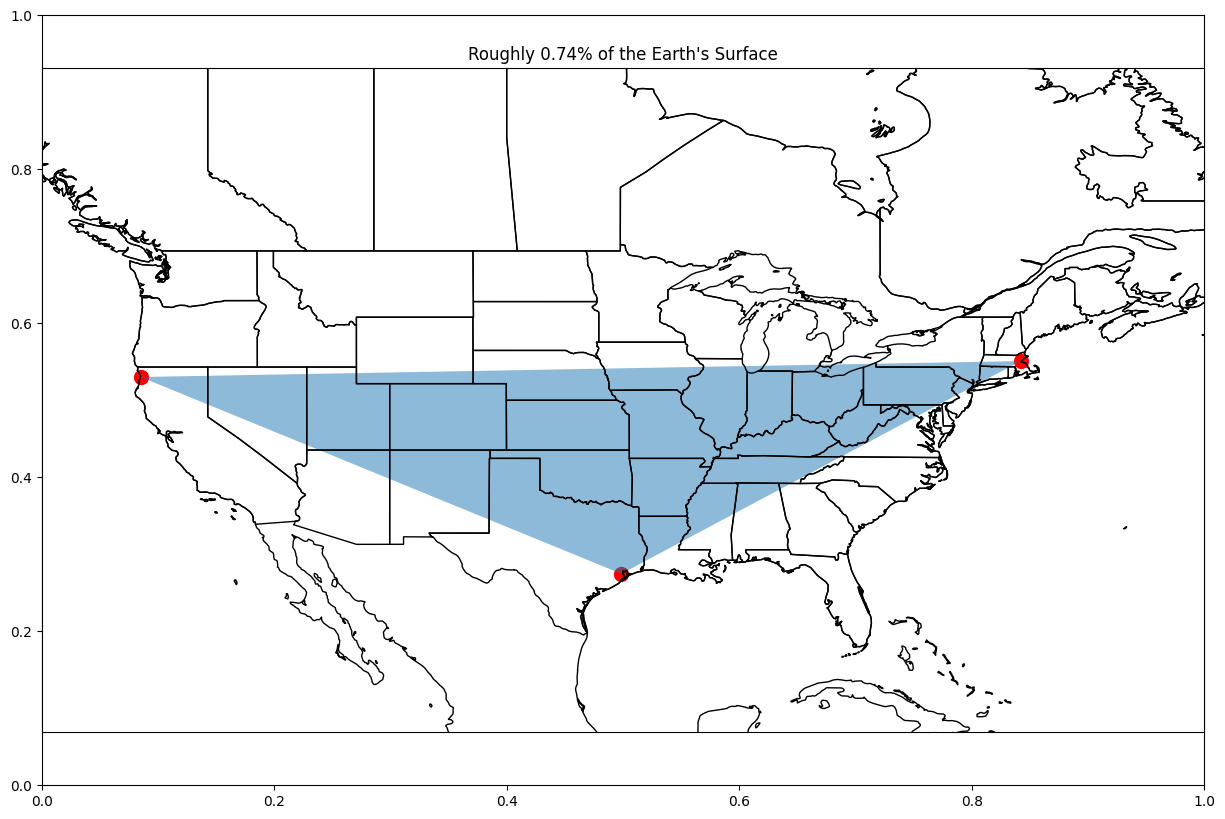

In [243]:
plot_area(["redwoods", "boston", "houston"], -130, -60, 20, 60)

### TODO
Fix invalid overlapping polygon by re-ordering points into a clockwise order

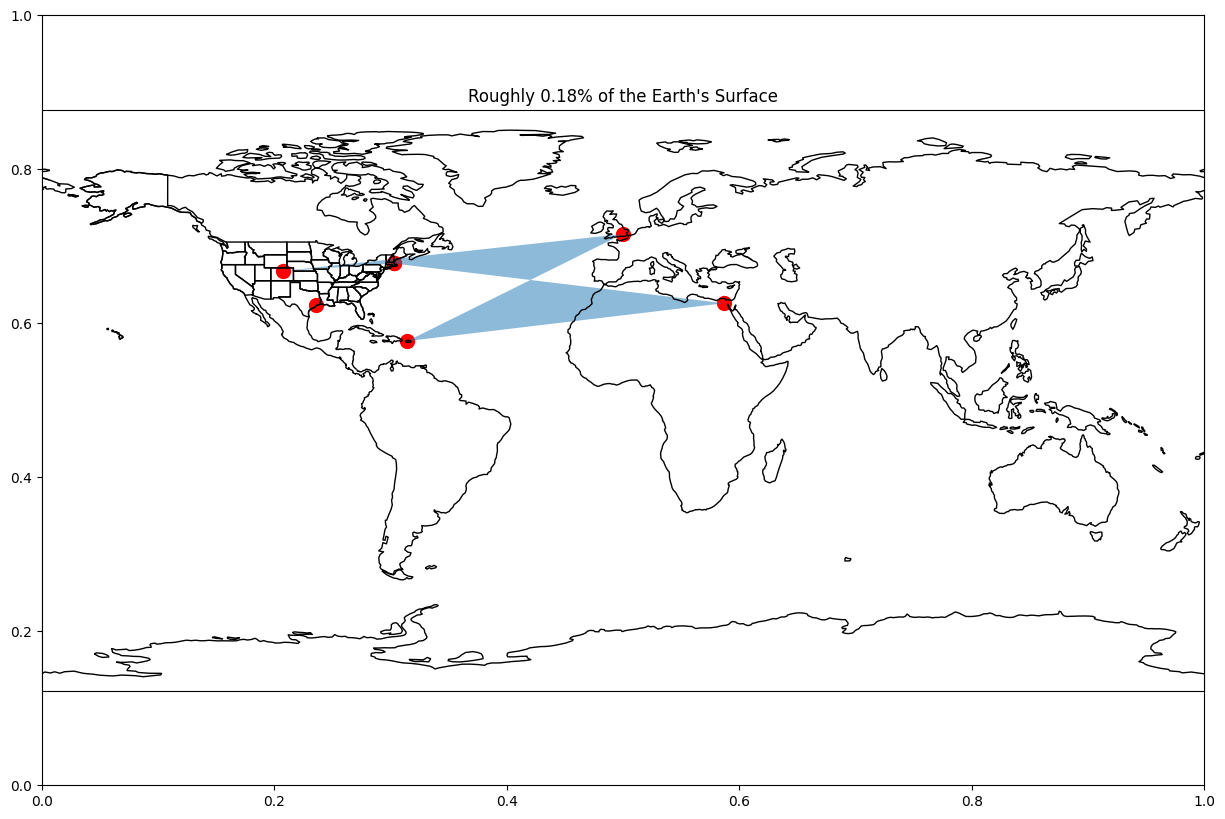

In [244]:
plot_area(["boulder", "boston", "houston", "boston", "cairo", "arecibo", "greenwich"])

## Determine if a given point is within a spherical polygon

In [245]:
def polygon_contains_point(pt=None, polygon_pts=None, tolerance_m=1):
    # tolerance in meters
    check_pt = Point((location_df.loc[[pt]]["longitude"].iloc[0], 
                      location_df.loc[[pt]]["latitude"].iloc[0]))
    longitudes = [location_df.loc[[x]]["longitude"].iloc[0] for x in polygon_pts]
    latitudes = [location_df.loc[[x]]["latitude"].iloc[0] for x in polygon_pts]
    lat_lon_coords = tuple(zip(longitudes, latitudes))
    polygon = Polygon(lat_lon_coords)
    contained_by_polygon = polygon.contains(check_pt)
    # check boundary conditions
    if not contained_by_polygon:
        contained_by_polygon = polygon.buffer(distance=tolerance_m/1000).contains(check_pt)
    return contained_by_polygon

In [246]:
polygon_contains_point("boulder", ["redwoods", "boston", "houston"])

True

In [247]:
def plot_polygon_pt(pt=None, polygon_pts=None, tolerance_m=1,
                   lon_west=-180, lon_east=180,
                   lat_south=-90, lat_north=90):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")

   # plot polygon points
    longitudes = [location_df.loc[[x]]["longitude"].iloc[0] for x in polygon_pts] # longitude
    latitudes = [location_df.loc[[x]]["latitude"].iloc[0] for x in polygon_pts] # latitude
    plt.scatter(longitudes, latitudes, s=50, c="blue")
    plt.fill(longitudes, latitudes, alpha=0.5)

    # plot check point
    contains_pt = polygon_contains_point(pt, polygon_pts, tolerance_m)
    if contains_pt:
        color="green"
    else:
        color="red"
    
    plt.scatter(location_df.loc[[pt]]["longitude"].iloc[0],
                location_df.loc[[pt]]["latitude"].iloc[0], s=100, c=color)


    plt.title(f"Point contained within polygon (tolerance {tolerance_m} m) = {contains_pt}")
    plt.show()

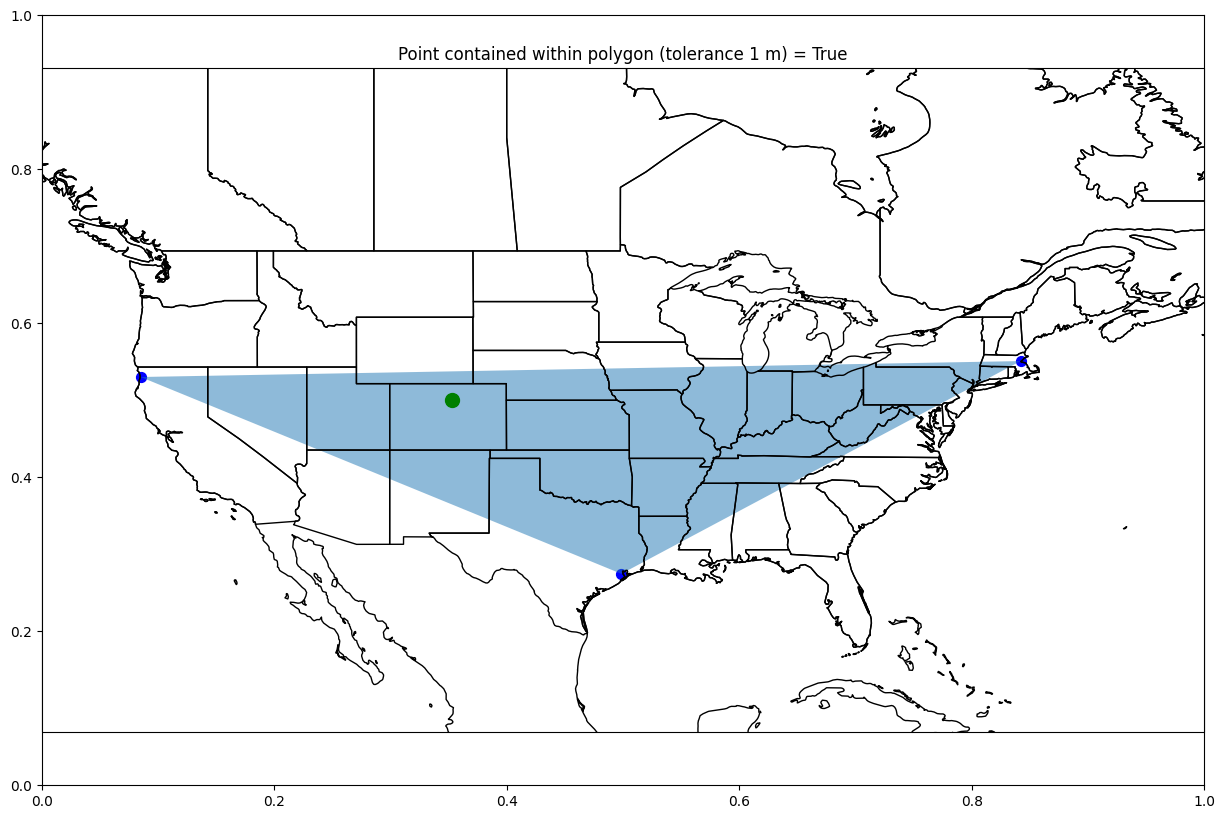

In [248]:
plot_polygon_pt("boulder", ["redwoods", "boston", "houston"], 1,
               -130, -60, 20, 60)

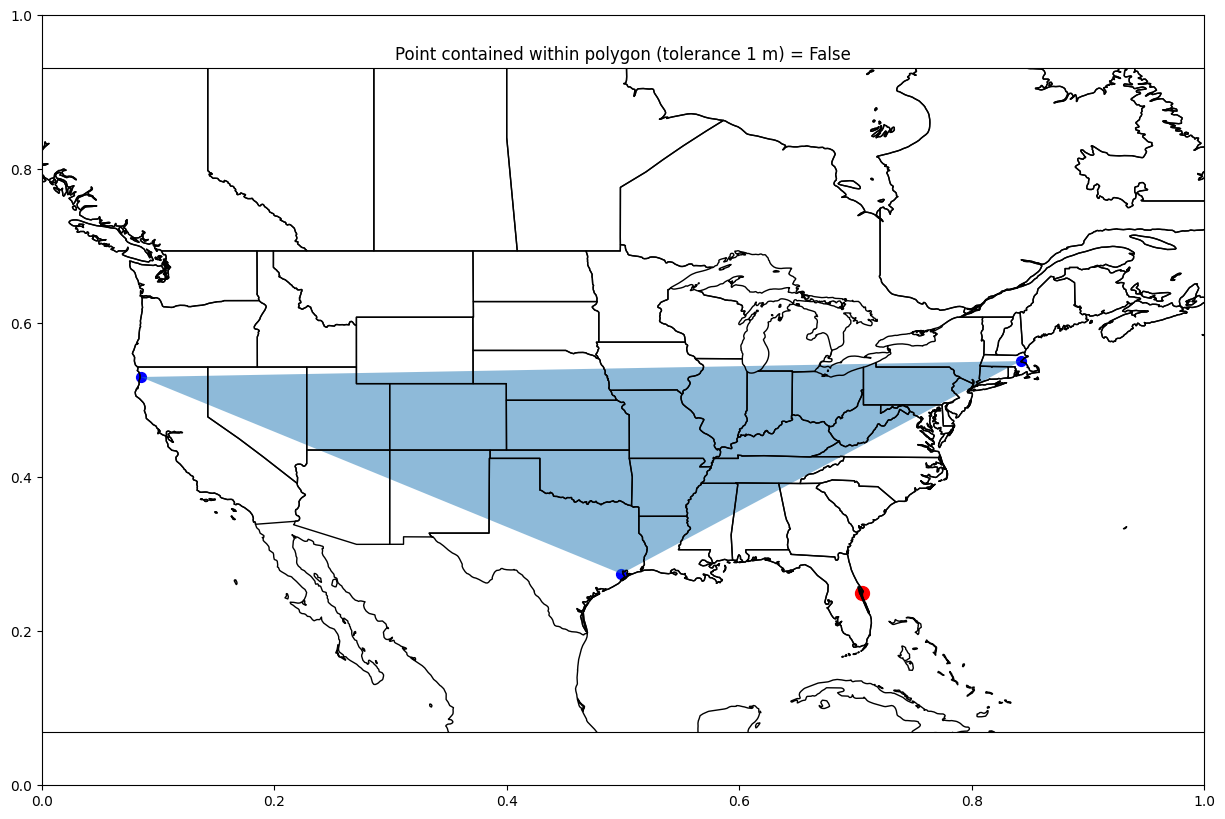

In [249]:
plot_polygon_pt("cape canaveral", ["redwoods", "boston", "houston"], 1,
               -130, -60, 20, 60)

## Determine if a given list of points is within a spherical polygon

In [277]:
def polygon_contains_points(pt_lst=None, polygon_pts=None, tolerance_m=1):
    # tolerance in meters
    longitudes = [location_df.loc[[x]]["longitude"].iloc[0] for x in polygon_pts]
    latitudes = [location_df.loc[[x]]["latitude"].iloc[0] for x in polygon_pts]
    lat_lon_coords = tuple(zip(longitudes, latitudes))
    polygon = Polygon(lat_lon_coords)
    contains = np.vectorize(lambda pt: polygon.contains(Point((location_df.loc[[pt]]["longitude"].iloc[0], location_df.loc[[pt]]["latitude"].iloc[0]))))
    contained_by_polygon = contains(np.array(pt_lst))
    return contained_by_polygon

In [298]:
def plot_polygon_pts(pt_lst=None, polygon_pts=None, tolerance_m=1,
                   lon_west=-180, lon_east=180,
                   lat_south=-90, lat_north=90):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")

   # plot polygon points
    longitudes = [location_df.loc[[x]]["longitude"].iloc[0] for x in polygon_pts] # longitude
    latitudes = [location_df.loc[[x]]["latitude"].iloc[0] for x in polygon_pts] # latitude
    plt.scatter(longitudes, latitudes, s=50, c="blue")
    plt.fill(longitudes, latitudes, alpha=0.5)

    # plot check points
    contains_pts = polygon_contains_points(pt_lst, polygon_pts, tolerance_m)
    longitudes = [location_df.loc[[x]]["longitude"].iloc[0] for x in np.array(pt_lst)[contains_pts]] # longitude
    latitudes = [location_df.loc[[x]]["latitude"].iloc[0] for x in np.array(pt_lst)[contains_pts]] # latitude
    plt.scatter(longitudes, latitudes, s=100, c="green", label="Within Polygon")
    longitudes = [location_df.loc[[x]]["longitude"].iloc[0] for x in np.array(pt_lst)[~contains_pts]] # longitude
    latitudes = [location_df.loc[[x]]["latitude"].iloc[0] for x in np.array(pt_lst)[~contains_pts]] # latitude
    plt.scatter(longitudes, latitudes, s=100, c="red", label="Not within Polygon")

    plt.legend(loc="lower left")
    plt.title(f"Points contained within polygon (tolerance {tolerance_m} m) = {np.array(pt_lst)[contains_pts]}")
    plt.show()

In [299]:
polygon_contains_points(["boulder", "cape canaveral"], ["redwoods", "boston", "houston"], 1)

array([ True, False])

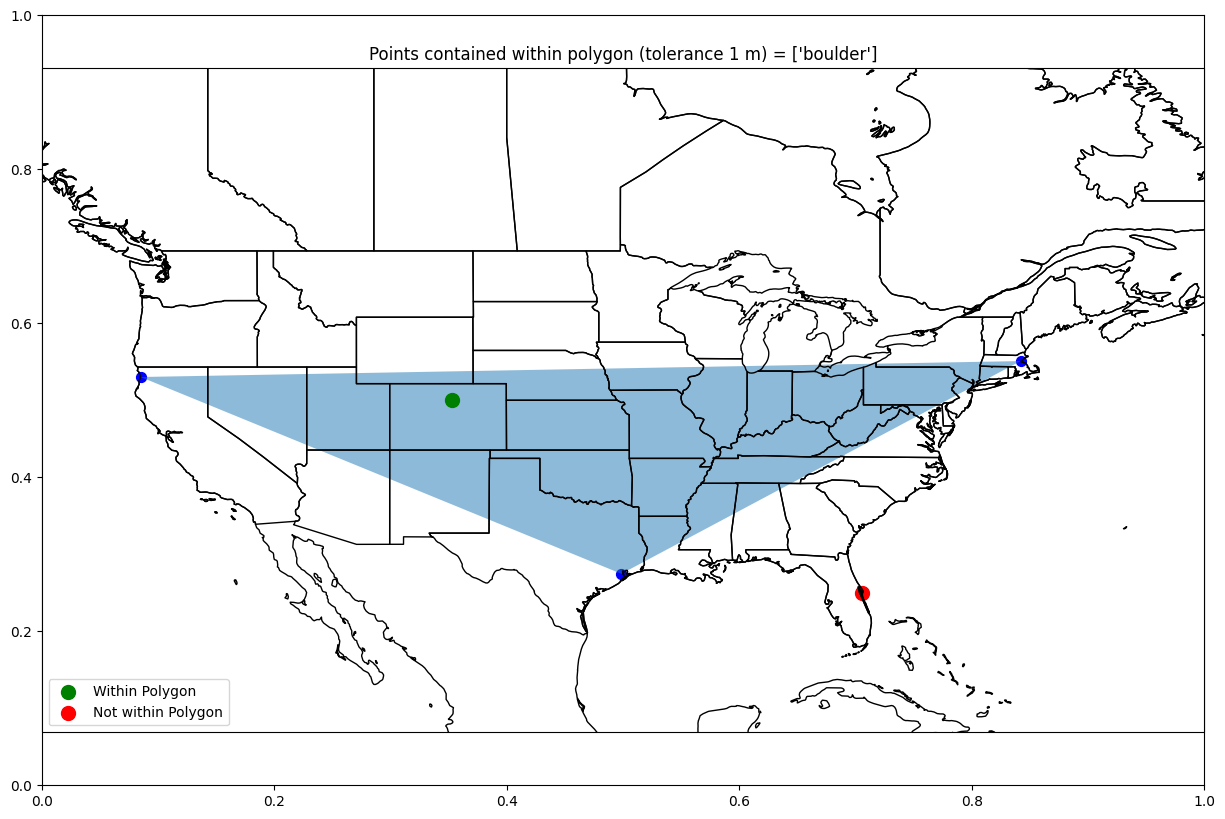

In [300]:
plot_polygon_pts(["boulder", "cape canaveral"], ["redwoods", "boston", "houston"], 1,
               -130, -60, 20, 60)

## Center of spherical polygon

In [ ]:
def polygon_centroid(polygon_pts=None):
    longitudes = [location_df.loc[[x]]["longitude"].iloc[0] for x in polygon_pts]
    latitudes = [location_df.loc[[x]]["latitude"].iloc[0] for x in polygon_pts]
    lat_lon_coords = tuple(zip(longitudes, latitudes))
    polygon = Polygon(lat_lon_coords)
    return (polygon.centroid.y, polygon.centroid.x)

In [ ]:
polygon_centroid(["boulder", "boston", "houston"])

In [ ]:
def plot_centroid(polygon_pts=None,
                   lon_west=-180, lon_east=180,
                   lat_south=-90, lat_north=90):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")

   # plot polygon points
    longitudes = [location_df.loc[[x]]["longitude"].iloc[0] for x in polygon_pts] # longitude
    latitudes = [location_df.loc[[x]]["latitude"].iloc[0] for x in polygon_pts] # latitude
    plt.scatter(longitudes, latitudes, s=50, c="blue")
    plt.fill(longitudes, latitudes, alpha=0.5)

    # plot check point
    centeroid = polygon_centroid(polygon_pts)
    plt.scatter(centeroid[1], centeroid[0], s=100, c="red")
    plt.title(f"Centeroid = {centeroid}")
    plt.show()

In [ ]:
plot_centroid(["boulder", "boston", "houston"],
               -130, -60, 20, 60)

In [ ]:
plot_centroid(["redwoods", "boulder", "cape canaveral", "houston"],
               -130, -60, 20, 60)

---

## Summary

### What's next?

## Resources and references
